In [96]:
import glob
import os
import sys
import time

import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from colorama import Fore, Style
from IPython import display
from scipy.spatial import ConvexHull
from sklearn.cluster import DBSCAN
%matplotlib inline

In [94]:
data_path = glob.glob('raw_dataset/*.csv')
data_length = len(data_path)

## 1. Evaluate clustering algorithms

In [16]:
# Initialize sample wafer and convert xy coordinates to mm
df = pd.read_csv(data_path[3])
df.rename(columns={'REAL_WAFER_X': 'X','REAL_WAFER_Y': 'Y'}, inplace=True)
df[['X', 'Y']] = df[['X', 'Y']]/1000

### Using DBSCAN

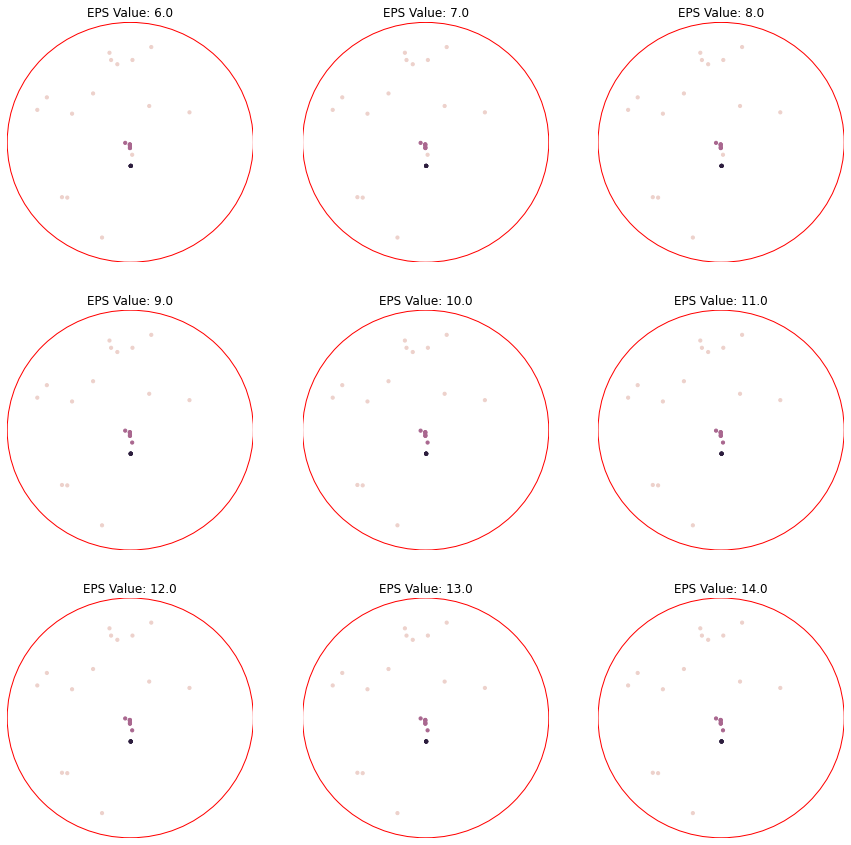

In [17]:
# Find optimal EPS value
fig, ax = plt.subplots(3, 3, figsize=(15,15))
ax = ax.flatten()
cmap = sns.cubehelix_palette(as_cmap=True)
for i, eps_val in enumerate(np.linspace(6, 14, 9)):
    clusterer = DBSCAN(eps=eps_val,min_samples=4).fit(df[['X', 'Y']])
    df['c_id'] = 1 + clusterer.labels_
    ax[i].scatter(df['X'], df['Y'], c=df['c_id'], s=10, cmap=cmap)
    circle = plt.Circle((0, 0), 150, color='r', fill=None)
    ax[i].add_patch(circle)
    ax[i].axis('off')
    ax[i].set_title('EPS Value: {}'.format(eps_val))
plt.setp(ax, xlim=[-150, 150], ylim=[-150, 150])
plt.show()
# Outcome: 10

### Using HDBSCAN

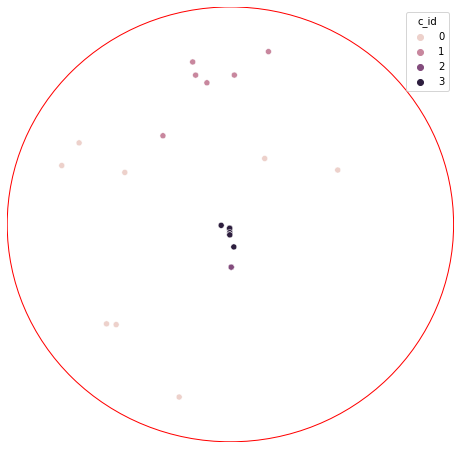

In [18]:
clusterer = hdbscan.HDBSCAN(min_samples=4)
clusterer.fit(df[['X', 'Y']])
df['c_id'] = 1 + clusterer.labels_
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=df, x='X', y='Y', hue='c_id')
circle = plt.Circle((0, 0), 150, color='r', fill=None)
ax.add_patch(circle)
ax.axis('off')
plt.setp(ax, xlim=[-150, 150], ylim=[-150, 150])
plt.show()

### Combine HDBSCAN and DBSCAN

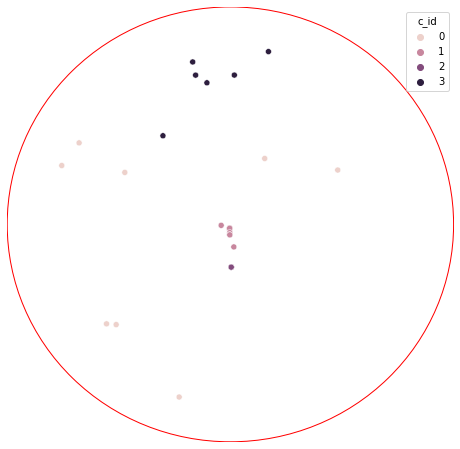

In [28]:
df = pd.read_csv(data_path[3])
df.rename(columns={'REAL_WAFER_X': 'X', 'REAL_WAFER_Y': 'Y'}, inplace=True)
df[['X', 'Y']] = df[['X', 'Y']]/1000

# Cluster with DBSCAN
clusterer = DBSCAN(eps=10, min_samples=4).fit(df[['X', 'Y']])
df['c_id'] = 1 + clusterer.labels_

# Cluster DBSCAN outliers with HDBSCAN
df_sub = df.copy()
clusterer = hdbscan.HDBSCAN(min_samples=4)
clusterer.fit(df_sub[['X', 'Y']])
df_sub['c_id'] = 1 + clusterer.labels_
df = pd.merge(df, df_sub[['X', 'Y', 'c_id']], 
              on=['X', 'Y'], suffixes=('', '_y'))
df.loc[
    (df['c_id'] == 0) & (df['c_id_y'] != 0), 'c_id'] = df.loc[
    (df['c_id'] == 0) & (df['c_id_y'] != 0), 'c_id_y'] + df['c_id'].max()
df.drop(columns='c_id_y', inplace=True)

# Drop any clusters that are less than 4 samples
cluster_size = df['c_id'].value_counts()
df.loc[df['c_id'].map(cluster_size) <= 4,'c_id'] = 0

# Display
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=df, x='X', y='Y', hue='c_id')
circle = plt.Circle((0, 0), 150, color='r', fill=None)
ax.add_patch(circle)
ax.axis('off')
plt.setp(ax, xlim=[-150, 150], ylim=[-150, 150])
plt.show()

## 2. Utilized optimal hyperparameters for clustering and label all data

In [ ]:
## Initialize variables for loop
labeled_path = glob.glob('labeled_dataset/*.csv')
label_col = ['none', 'scratch', 'focus_spot']
exit = 0

# Loop through each data file in folder
for csv_id, csv in enumerate(data_path):
    if csv.replace('raw_dataset', 'labeled_dataset') not in labeled_path:
        df = pd.read_csv(csv)
        df.rename(columns={'REAL_WAFER_X': 'X', 'REAL_WAFER_Y': 'Y'}, 
                  inplace=True)
        df[['X', 'Y']] = df[['X', 'Y']]/1000
        
        # Cluster with DBSCAN
        clusterer = DBSCAN(eps=10, min_samples=4).fit(df[['X', 'Y']])
        df['c_id'] = 1 + clusterer.labels_

        # Cluster DBSCAN outliers with HDBSCAN
        df_sub = df.copy()
        clusterer = hdbscan.HDBSCAN(min_samples=4)
        clusterer.fit(df_sub[['X', 'Y']])
        df_sub['c_id'] = 1 + clusterer.labels_
        df = pd.merge(df, df_sub[['X', 'Y', 'c_id']], 
                      on=['X', 'Y'], suffixes=('', '_y'))
        df.loc[
            (df['c_id'] == 0) & (df['c_id_y'] != 0), 'c_id'] = df.loc[
            (df['c_id'] == 0) & (df['c_id_y'] != 0),
            'c_id_y'] + df['c_id'].max()
        df.drop(columns='c_id_y', inplace=True)

        # Any clusters that are less than 4 samples are not considered issues
        cluster_size = df['c_id'].value_counts()
        df.loc[df['c_id'].map(cluster_size) <= 4, 'c_id'] = 0
        
        # Initialize label columns
        for col in label_col:
            df[col] = 0
        
        # Loop through clusters and label
        for c_id, cluster_df in df.groupby('c_id'):
            display.clear_output(wait=False)
            if c_id != 0:
                fig, ax = plt.subplots(figsize=(8, 8))
                ax.axis('off')
                sns.scatterplot(data=df[df['c_id'] != c_id], x='X', y='Y', 
                                ax=ax)
                sns.scatterplot(data=cluster_df, x='X', y='Y', ax=ax, 
                                color='r')
                circle = plt.Circle((0, 0), 150, color='r', fill=None)
                ax.add_patch(circle)
                plt.setp(ax, xlim=[-150, 150], ylim=[-150, 150])
                plt.show()
                gfa_label = input("Key:\n" \
                                  "No Issue = 0\n" \
                                  "Scratch = 1\n" \
                                  "Focus Spot = 2\n" \
                                  "To Exit input \'exit\'\n" \
                                  "Label: ")
                if gfa_label == 'exit':
                    exit = 1
                    break
                else:
                    df.loc[df['c_id'] == c_id, label_col[int(gfa_label)]] = 1
        if exit == 1:
            break
        dest = csv.replace('raw_dataset', 'labeled_dataset')
        df.to_csv(dest, index=False)
        print('%d of %d' % (csv_id + 1, data_length))
        time.sleep(1)

In [ ]:
# Definitely need to think about this more...  One Wafer can have multiple classifications...
# Multilabel Classification
# [1 0 0]
# [0 1 0]
# [0 0 1]
# No folders in labeled_data folder

# This should be how the program runs:
# First groups with (H?)DBSCAN, perform feature calculations (gfa area, etc.) on groups, then label based on features.

In [ ]:
# Predict whether it is nothing, scratch, or focus spot
# Goal: Predict whether somethings is nothing, scratch, focus spot
# This is a multi-class problem.
# Can expand it to a binary classification problem for burp or not.